In [1]:
#imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [15]:
%run dataloader.ipynb

train size:  7614
dev size:  980
test size:  994


In [16]:
batch_size=500
train_dataloader = DataLoader(train_set, collate_fn=collate_fn, batch_size=batch_size, shuffle=True)
dev_dataloader = DataLoader(dev_set, collate_fn=collate_fn, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, collate_fn=collate_fn, batch_size=batch_size, shuffle=True)

In [17]:
gpu_id = 'cuda:3'
device = torch.device(gpu_id if torch.cuda.is_available() else 'cpu')

In [18]:
# random
class Random():

    def __init__(self) -> None:
        pass
    
    def predict(self, x):
        return torch.tensor([[random.randint(0,1)] for i in range(x.shape[0])], dtype=torch.int64, device=device)

In [19]:
random_baseline = Random()
matches = 0
total = 0
for batch_idx, batch in enumerate(test_dataloader, 0): 
    x_p,x_c,y,hid,x_p_len=map(lambda x: x.to(device), batch)
    predictions = random_baseline.predict(x_p)
    matches += (y == predictions).sum()
    total += len(y)
acc = matches / total
print('test accuracy: {:.2%}'.format(float(acc)))

/tmp/ipykernel_2593114/324524730.py:101: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_w=np.array(self.language_sdk[hid]['context_embedding_indexes'])
/tmp/ipykernel_2593114/324524730.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_of=np.array(self.word_aligned_openface_sdk[hid]['context_features'])
/tmp/ipykernel_2593114/324524730.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you mea

test accuracy: 51.84%


In [21]:
# single layer linear
class SingleLayer(torch.nn.Module):

    def __init__(self) -> None:
        super().__init__()
        self.w = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, 1.0, (20*300, 1)), dtype=torch.float32))
        self.b = torch.nn.Parameter(torch.zeros((1,), dtype=torch.float32))

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        return x@self.w + self.b


step error


/tmp/ipykernel_2593114/324524730.py:101: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_w=np.array(self.language_sdk[hid]['context_embedding_indexes'])
/tmp/ipykernel_2593114/324524730.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_of=np.array(self.word_aligned_openface_sdk[hid]['context_features'])
/tmp/ipykernel_2593114/324524730.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you mea

1 6.227977275848389
dev accuracy: 52.63%
2 6.793231010437012
dev accuracy: 52.63%
3 6.386241912841797
dev accuracy: 52.84%
4 7.88186502456665
dev accuracy: 52.63%
5 5.656401634216309
dev accuracy: 52.32%
6 5.440649509429932
dev accuracy: 52.12%
7 7.4419450759887695
dev accuracy: 51.81%
8 5.325762748718262
dev accuracy: 52.12%
9 5.3862080574035645
dev accuracy: 52.32%
10 4.99655294418335
dev accuracy: 52.12%
11 5.7836480140686035
dev accuracy: 52.32%
12 5.864660263061523
dev accuracy: 52.43%
13 4.8817877769470215
dev accuracy: 52.32%
14 4.470452785491943
dev accuracy: 51.91%
15 4.154756546020508
dev accuracy: 51.81%
16 4.766878604888916
dev accuracy: 52.01%
17 4.209429740905762
dev accuracy: 52.22%
18 4.253148078918457
dev accuracy: 52.53%
19 5.971533298492432
dev accuracy: 52.53%
20 4.992188930511475
dev accuracy: 52.53%


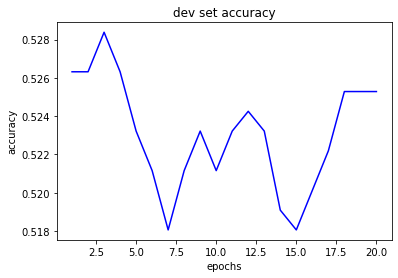

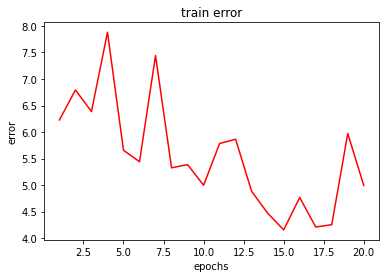

In [22]:
singlelayer_baseline = SingleLayer()
singlelayer_baseline.to(device)

optimiser = torch.optim.Adam(singlelayer_baseline.parameters(), lr=0.001)
epochs = 20

print('step', 'error')
dev_accs = []
errors = []
for epoch in range(1, epochs+1):
    for batch_idx, batch in enumerate(train_dataloader, 0): 
        x_p,x_c,y,hid,x_p_len=map(lambda x: x.to(device), batch)

        optimiser.zero_grad()
        output = singlelayer_baseline(x_p[:, :, :300])
        error = torch.nn.functional.binary_cross_entropy_with_logits(output, y)
        error.backward()
        optimiser.step()
    
    print(epoch, error.detach().tolist())
    errors.append(error.detach().tolist())

    with torch.no_grad():
        matches = 0
        total = 0
        for batch_idx, batch in enumerate(dev_dataloader, 0): 
            x_p,x_c,y,hid,x_p_len=map(lambda x: x.to(device), batch)
            outputs = torch.sigmoid(singlelayer_baseline(x_p[:, :, :300]))
            predictions = (outputs > 0.5)*1
            matches += (y == predictions).sum()
            total += len(y)
        acc = matches / total
        dev_accs.append(float(acc))
        print('dev accuracy: {:.2%}'.format(float(acc)))

plt.plot(range(1, epochs+1), dev_accs, 'b')
plt.title('dev set accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

plt.plot(range(1, epochs+1), errors, 'r')
plt.title('train error')
plt.xlabel('epochs')
plt.ylabel('error')
plt.show()

In [23]:
with torch.no_grad():
    matches = 0
    total = 0
    for batch_idx, batch in enumerate(test_dataloader, 0): 
        x_p,x_c,y,hid,x_p_len=map(lambda x: x.to(device), batch)
        outputs = torch.sigmoid(singlelayer_baseline(x_p[:, :, :300]))
        predictions = (outputs > 0.5)*1
        matches += (y == predictions).sum()
        total += len(y)
    acc = matches / total
    print('test accuracy: {:.2%}'.format(float(acc)))

/tmp/ipykernel_2593114/324524730.py:101: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_w=np.array(self.language_sdk[hid]['context_embedding_indexes'])
/tmp/ipykernel_2593114/324524730.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_of=np.array(self.word_aligned_openface_sdk[hid]['context_features'])
/tmp/ipykernel_2593114/324524730.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you mea

test accuracy: 52.86%


In [24]:
# multi layer linear
class MultiLayer(torch.nn.Module):

    def __init__(self, hidden_layer_size) -> None:
        super().__init__()
        self.w1 = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, 1.0, (20*300, hidden_layer_size)), dtype=torch.float32))
        self.b1 = torch.nn.Parameter(torch.zeros((hidden_layer_size,), dtype=torch.float32))
        self.w2 = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, 1.0, (hidden_layer_size, 1)), dtype=torch.float32))
        self.b2 = torch.nn.Parameter(torch.zeros((1,), dtype=torch.float32))

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        hidden = torch.nn.functional.leaky_relu(x@self.w1 + self.b1)
        return hidden@self.w2 + self.b2


step error


/tmp/ipykernel_2593114/324524730.py:101: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_w=np.array(self.language_sdk[hid]['context_embedding_indexes'])
/tmp/ipykernel_2593114/324524730.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_of=np.array(self.word_aligned_openface_sdk[hid]['context_features'])
/tmp/ipykernel_2593114/324524730.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you mea

1 45.46464538574219
dev accuracy: 49.54%
2 44.23741149902344
dev accuracy: 50.67%
3 44.33191680908203
dev accuracy: 51.39%
4 34.359127044677734
dev accuracy: 51.60%
5 20.140201568603516
dev accuracy: 52.12%
6 25.579471588134766
dev accuracy: 52.94%
7 24.40250587463379
dev accuracy: 53.56%
8 13.661542892456055
dev accuracy: 53.25%
9 22.03642463684082
dev accuracy: 53.66%
10 18.332763671875
dev accuracy: 53.87%
11 14.300353050231934
dev accuracy: 53.56%
12 10.290721893310547
dev accuracy: 53.87%
13 9.364069938659668
dev accuracy: 53.77%
14 7.967880725860596
dev accuracy: 53.87%
15 5.478631973266602
dev accuracy: 53.66%
16 4.937790393829346
dev accuracy: 53.87%
17 7.711990833282471
dev accuracy: 53.04%
18 2.0788381099700928
dev accuracy: 53.66%
19 4.87299108505249
dev accuracy: 53.97%
20 2.243990659713745
dev accuracy: 53.25%


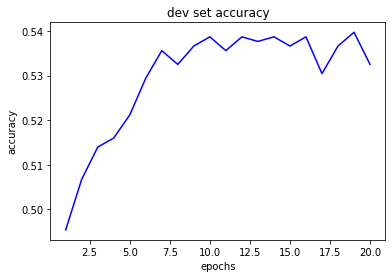

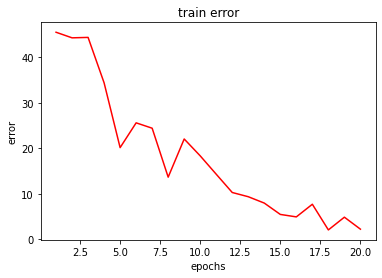

In [30]:
device = torch.device(gpu_id if torch.cuda.is_available() else 'cpu')
multilayer_baseline = MultiLayer(hidden_layer_size=256)
multilayer_baseline.to(device)

optimiser = torch.optim.Adam(multilayer_baseline.parameters(), lr=0.001)
epochs = 20

print('step', 'error')
dev_accs = []
errors = []
for epoch in range(1, epochs+1):
    for batch_idx, batch in enumerate(train_dataloader, 0): 
        x_p,x_c,y,hid,x_p_len=map(lambda x: x.to(device), batch)

        optimiser.zero_grad()
        output = multilayer_baseline(x_p[:, :, :300])
        error = torch.nn.functional.binary_cross_entropy_with_logits(output, y)
        error.backward()
        optimiser.step()
    
    print(epoch, error.detach().tolist())
    errors.append(error.detach().tolist())

    with torch.no_grad():
        matches = 0
        total = 0
        for batch_idx, batch in enumerate(dev_dataloader, 0): 
            x_p,x_c,y,hid,x_p_len=map(lambda x: x.to(device), batch)
            outputs = torch.sigmoid(multilayer_baseline(x_p[:, :, :300]))
            predictions = (outputs > 0.5)*1
            matches += (y == predictions).sum()
            total += len(y)
        acc = matches / total
        dev_accs.append(float(acc))
        print('dev accuracy: {:.2%}'.format(float(acc)))

plt.plot(range(1, epochs+1), dev_accs, 'b')
plt.title('dev set accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

plt.plot(range(1, epochs+1), errors, 'r')
plt.title('train error')
plt.xlabel('epochs')
plt.ylabel('error')
plt.show()

In [31]:
with torch.no_grad():
    matches = 0
    total = 0
    for batch_idx, batch in enumerate(test_dataloader, 0): 
        x_p,x_c,y,hid,x_p_len=map(lambda x: x.to(device), batch)
        outputs = torch.sigmoid(multilayer_baseline(x_p[:, :, :300]))
        predictions = (outputs > 0.5)*1
        matches += (y == predictions).sum()
        total += len(y)
    acc = matches / total
    print('test accuracy: {:.2%}'.format(float(acc)))

/tmp/ipykernel_2593114/324524730.py:101: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_w=np.array(self.language_sdk[hid]['context_embedding_indexes'])
/tmp/ipykernel_2593114/324524730.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_of=np.array(self.word_aligned_openface_sdk[hid]['context_features'])
/tmp/ipykernel_2593114/324524730.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you mea

test accuracy: 56.22%
